In [227]:
import pandas as pd
import glob
import collections
from collections import Counter
import time
from datetime import timedelta
import csv
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from datetime import datetime
from functools import reduce
from scipy import stats
import math
import re

In [2]:
path1 = "../Desktop/raw_kickstarter_data/"
path2 = "../Desktop/cleaned_kickstarter_data/"

count = 0
# import data
for foldername in glob.glob(path1 + "*"):
    print(foldername)
    frames = []
    for filename in glob.glob(foldername + "/*.csv"):
        if count == 0:
            df = pd.read_csv(filename)
            count += 1
        else:
            df = pd.read_csv(filename, header = 0)
        frames.append(df)

../Desktop/raw_kickstarter_data/2017-10
../Desktop/raw_kickstarter_data/2018-05
../Desktop/raw_kickstarter_data/2018-02
../Desktop/raw_kickstarter_data/2017-11
../Desktop/raw_kickstarter_data/2018-03
../Desktop/raw_kickstarter_data/2018-04
../Desktop/raw_kickstarter_data/2016-11
../Desktop/raw_kickstarter_data/2019-03
../Desktop/raw_kickstarter_data/2019-04
../Desktop/raw_kickstarter_data/2016-10
../Desktop/raw_kickstarter_data/2019-02
../Desktop/raw_kickstarter_data/2016-04
../Desktop/raw_kickstarter_data/2016-03
../Desktop/raw_kickstarter_data/2016-05
../Desktop/raw_kickstarter_data/2018-10
../Desktop/raw_kickstarter_data/2017-02
../Desktop/raw_kickstarter_data/2017-05
../Desktop/raw_kickstarter_data/2018-11
../Desktop/raw_kickstarter_data/2017-04
../Desktop/raw_kickstarter_data/2017-03
../Desktop/raw_kickstarter_data/2018-08
../Desktop/raw_kickstarter_data/2018-01
../Desktop/raw_kickstarter_data/2018-06
../Desktop/raw_kickstarter_data/2018-07
../Desktop/raw_kickstarter_data/2018-09


In [247]:
### INITIAL DATA CLEANING

projects_id = []
df1 = pd.DataFrame()
df1_success = pd.DataFrame()
df1_fail = pd.DataFrame()

df1 = pd.concat(frames, axis = 0, join = 'inner')

# remove unnecessary columns
to_drop = ['blurb','currency','currency_symbol','disable_communication','launched_at',
           'location','photo','pledged','profile','slug','spotlight','staff_pick',
           'state_changed_at','static_usd_rate']
df1.drop(to_drop, inplace=True, axis=1)

category_id1 = []
creator_id1 = []
category_name1 = []
url1 = []

# extract category id
for c1 in df1['category']:
    start_idx = c1.find('"id":') + 5
    end_idx1 = c1.find('"position":') - 1
    end_idx2 = c1.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    category_id1.append(c1[start_idx:end_idx])

# extract creator id
for c2 in df1['creator']:
    start_idx = c2.find('"id":') + 5
    end_idx1 = c2.find('"avatar":') - 1
    end_idx2 = c2.find('"name":') - 1
    end_idx = 0
    if (start_idx < end_idx1 and start_idx < end_idx2):
        end_idx = min(end_idx1, end_idx2)
    else:
        end_idx = max(end_idx1, end_idx2)
    creator_id1.append(c2[start_idx:end_idx])

# extract category name
for c3 in df1['category']:
    start_idx = c3.find('"slug":') + 8
    end_idx = c3.find('"position":') - 2
    category_name1.append(c3[start_idx:end_idx])

# extract project url
for u1 in df1['urls']:
    start_idx = u1.find('"project":"') + 11
    end_idx = u1.find('"rewards":') - 2
    url1.append(u1[start_idx:end_idx])

# define new columns
df1['category_id'] = category_id1
df1['creator_id'] = creator_id1
df1['category_name'] = category_name1
df1['url'] = url1

# rearranging columns
df1 = df1[['creator_id','id','name','created_at','deadline','category_id','category_name',
           'goal','usd_pledged','backers_count','state','url', 'country']]

# convert epoch to datetime
df1['created_at'] = pd.to_datetime(df1['created_at'],unit='s')
df1['deadline'] = pd.to_datetime(df1['deadline'],unit='s')

# only keep US companies that were not cancelled
df1 = df1.loc[(df1['country'] == 'US') & (df1['state'].isin(['successful','failed'])) & 
                  (df1['goal'] > 2500) & (df1['usd_pledged'] > 25)]
df1_success = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'successful') & 
                      (df1['goal'] > 2500) & (df1['usd_pledged'] > 25)]
df1_fail = df1.loc[(df1['country'] == 'US') & (df1['state'] == 'failed') & 
                       (df1['goal'] > 2500)& (df1['usd_pledged'] > 25)]

df1.drop(['country'], inplace = True, axis = 1)
df1_success.drop(['country'], inplace = True, axis = 1)
df1_fail.drop(['country'], inplace = True, axis = 1)

# remove duplicates
df1 = df1.drop_duplicates('id')
projects_id = projects_id + list(df1['id'])
df1_success = df1_success.drop_duplicates('id')
df1_fail = df1_fail.drop_duplicates('id')


/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


{0: 0.2847919751357264, 1: 18.331399148958877, 2: 52.729867808502405, 3: 75.55724518788267, 4: 84.51718756252751, 5: 88.89377992983579, 6: 91.49959315432123, 7: 93.19167100190751, 8: 94.40553843691224, 9: 95.3019328504542, 10: 95.9695599397068, 11: 96.49312364106873, 12: 96.93931996745235, 13: 97.32882468286046, 14: 97.6482985847106, 15: 97.91108087558526, 16: 98.14318300052022, 17: 98.3325996771913, 18: 98.48933530753531, 19: 98.6394013365881, 20: 98.77346032254192, 21: 98.88617658436378, 22: 98.98221884295756, 23: 99.06425493883975, 24: 99.1396214334307, 25: 99.22365840970026, 26: 99.29835794416209, 27: 99.35971827604146, 28: 99.41440900662958, 29: 99.46243013592647, 30: 99.50644950444863, 31: 99.54046447103393, 32: 99.5738124774901, 33: 99.6078274440754, 34: 99.63917457014419, 35: 99.6678538556965, 36: 99.68652873931197, 37: 99.70587058305655, 38: 99.72921418757586, 39: 99.75455867248256, 40: 99.78190403777663, 41: 99.80458068216682, 42: 99.82325556578228, 43: 99.83726172849387, 44:

Text(0.5, 1.0, 'Percentile of All Projects')

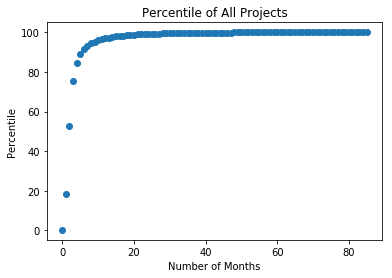

In [248]:
df2 = df1.copy()

df2['duration'] = (df2['deadline'] - df2['created_at']) / np.timedelta64(1,'M')

num_months = round(max(df2['duration']))

# dictionary for all_projects
new_dict = {}
for i in range(num_months): # set up blank dictionary
    new_dict[i] = 0
for j in df2['duration']:
    if round(j) < num_months - 1: # round duration into number of months
        new_dict[round(j)] += 1
    else:
        new_dict[num_months - 1] += 1
        
lst = []
for k,v in new_dict.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(dict_distr)
    
plt.scatter(dict_distr.keys(),dict_distr.values())
plt.xlabel('Number of Months')
plt.ylabel('Percentile')
plt.title('Percentile of All Projects')

{0: 0.2616788172524742, 1: 17.71983057060237, 2: 51.96513664318006, 3: 75.42459169958865, 4: 84.71266240377958, 5: 89.19887590111188, 6: 91.80955484054901, 7: 93.47737547346557, 8: 94.6462754042276, 9: 95.54025984604732, 10: 96.22347574634465, 11: 96.74072414776198, 12: 97.17447969698203, 13: 97.55325214841363, 14: 97.86075021382315, 15: 98.12242903107563, 16: 98.35559809391928, 17: 98.53989329206208, 18: 98.69262411925223, 19: 98.83008186372338, 20: 98.93801164827109, 21: 99.02863193907058, 22: 99.12128864089928, 23: 99.19459943795056, 24: 99.25060074125362, 25: 99.31780230521728, 26: 99.37787643057875, 27: 99.4328595283672, 28: 99.48682442064106, 29: 99.5306072577689, 30: 99.56522624526535, 31: 99.58966317761578, 32: 99.6202093430538, 33: 99.65177371400644, 34: 99.67926526290066, 35: 99.70675681179489, 36: 99.72202989451391, 37: 99.73832118274753, 38: 99.75868529303955, 39: 99.78312222538997, 40: 99.8126501853134, 41: 99.83199609009083, 42: 99.84523276178064, 43: 99.85643302244125, 4

Text(0.5, 1.0, 'Percentile of Successful Projects')

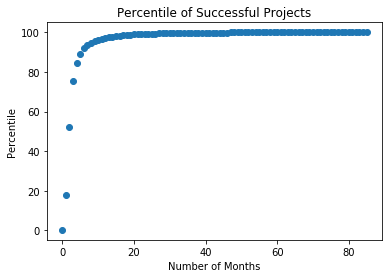

In [249]:
# dictionary for successful projects

df2_success = df1_success.copy()

df2_success['duration'] = (df2_success['deadline'] - df2_success['created_at']) / np.timedelta64(1,'M')
new_dict_success = {}

for i in range(num_months):
    new_dict_success[i] = 0
for j in df2_success['duration']:
    if round(j) < num_months - 1:
        new_dict_success[round(j)] += 1
    else:
        new_dict_success[num_months - 1] += 1
        
lst = []
for k,v in new_dict_success.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict_success.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(dict_distr)
    
plt.scatter(dict_distr.keys(),dict_distr.values())
plt.xlabel('Number of Months')
plt.ylabel('Percentile')
plt.title('Percentile of Successful Projects')

{0: 0.3306136653648351, 1: 19.494605777038785, 2: 54.183906268125746, 3: 75.8110668574301, 4: 84.14794478171764, 5: 88.31638374386141, 6: 90.9129577355864, 7: 92.65109624531148, 8: 93.95034994779785, 9: 94.85132052124821, 10: 95.4893468930049, 11: 96.02490236263098, 12: 96.49472178183365, 13: 96.90460539035614, 14: 97.24681953520745, 15: 97.51169715014888, 16: 97.74177332663083, 17: 97.94091489114884, 18: 98.10525501720738, 19: 98.27926220950467, 20: 98.46293646804068, 21: 98.61760952786048, 22: 98.7200804299911, 23: 98.81868450562624, 24: 98.93082247399559, 25: 99.04682726886044, 26: 99.14929817099107, 27: 99.22276787440548, 28: 99.27883685859015, 29: 99.33490584277483, 30: 99.39677506670276, 31: 99.44897722439194, 32: 99.48764548934689, 33: 99.52631375430184, 34: 99.5649820192568, 35: 99.59591663122076, 36: 99.62105100344148, 37: 99.6461853756622, 38: 99.6751865743784, 39: 99.70225435984688, 40: 99.72545531881984, 41: 99.75445651753606, 42: 99.78345771625227, 43: 99.80279184872975, 4

Text(0.5, 1.0, 'Percentile of Failed Projects')

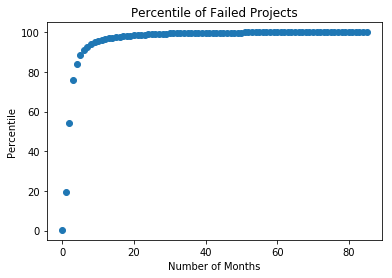

In [250]:
# dictionary for failed projects

df2_fail = df1_fail.copy()
df2_fail['duration'] = (df2_fail['deadline'] - df2_fail['created_at']) / np.timedelta64(1,'M')
new_dict_fail = {}

for i in range(num_months):
    new_dict_fail[i] = 0
for j in df2_fail['duration']:
    if round(j) < num_months - 1:
        new_dict_fail[round(j)] += 1
    else:
        new_dict_fail[num_months - 1] += 1

lst = []
for k,v in new_dict_fail.items():
    for i in range(v):
        lst.append(k)

dict_distr = {}
for i in new_dict_fail.keys():
    dict_distr[i] = stats.percentileofscore(lst, i)
    
print(dict_distr)
    
plt.scatter(dict_distr.keys(),dict_distr.values())
plt.xlabel('Number of Months')
plt.ylabel('Percentile')
plt.title('Percentile of Failed Projects')

In [251]:
# dictionary for probability of success
new_dict_success_rate = {}

for i in new_dict.keys():
    if new_dict[i] > 20: # sufficient number of projects with that duration
        new_dict_success_rate[i] = new_dict_success[i] / new_dict[i]

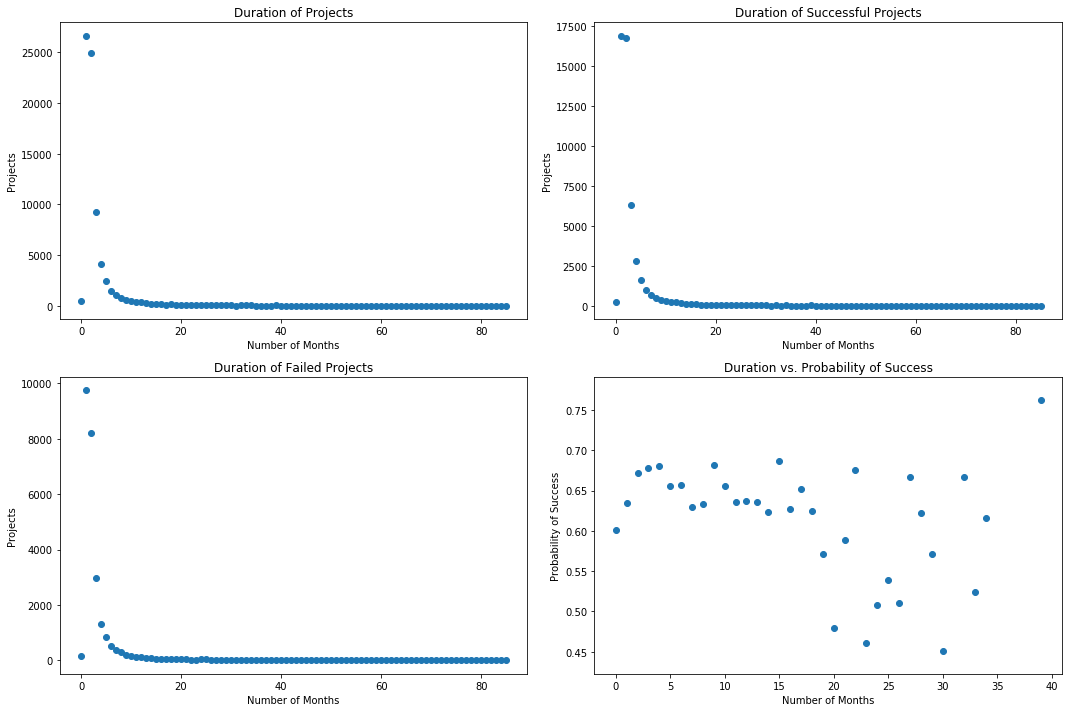

In [252]:
path3 = "../Desktop/cleaned_kickstarter_plots/"

fig = plt.figure(figsize=(15, 10))

# PLOT DURATION VS NUMBER OF PROEJCTS
plt.subplot(2, 2, 1)
plt.scatter(new_dict.keys(),new_dict.values())
plt.xlabel('Number of Months')
plt.ylabel('Projects')
plt.title('Duration of Projects')

# PLOT DURATION VS NUMBER OF SUCCESSFUL PROEJCTS
plt.subplot(2, 2, 2)
plt.scatter(new_dict_success.keys(),new_dict_success.values())
plt.xlabel('Number of Months')
plt.ylabel('Projects')
plt.title('Duration of Successful Projects')

# PLOT DURATION VS NUMBER OF FAILED PROEJCTS
plt.subplot(2, 2, 3)
plt.scatter(new_dict_fail.keys(),new_dict_fail.values())
plt.xlabel('Number of Months')
plt.ylabel('Projects')
plt.title('Duration of Failed Projects')

# PLOT DURATION VS SUCCESS RATE
plt.subplot(2, 2, 4)
plt.scatter(new_dict_success_rate.keys(),new_dict_success_rate.values())
plt.xlabel('Number of Months')
plt.ylabel('Probability of Success')
plt.title('Duration vs. Probability of Success')

plt.tight_layout()

plt.savefig(path3 + 'Monthy_duration_number_success_fail_prob_success.png')

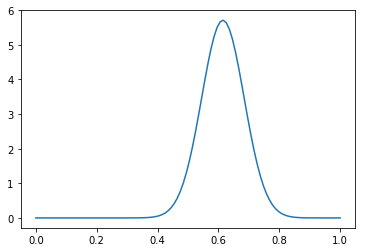

Duration = 0-32 Months
Mean: 0.614741384728358
Standard Deviation: 0.06984126574197673


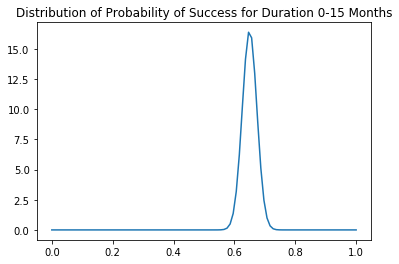

Duration = 0-15 Months
Mean: 0.6498707872269962
Standard Deviation: 0.024118815711846233


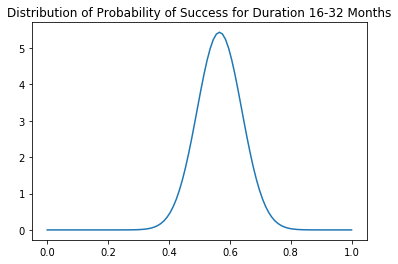

Duration = 16-32 Months
Mean: 0.5659308119416985
Standard Deviation: 0.07345445620732229


In [279]:
# variance of success rate

x = list(new_dict_success_rate.values())

var = np.var(x)
mean = np.mean(x)
sd = math.sqrt(var)
x_axis = np.linspace(0, 1, 100)
plt.plot(x_axis, norm.pdf(x_axis, mean, sd))
plt.show()

print('Duration = 0-32 Months')
print('Mean: ' + str(mean))
print('Standard Deviation: ' + str(sd))

var1 = np.var(x[0:16])

mean1 = np.mean(x[0:16])
sd1 = math.sqrt(var1)
x_axis = np.linspace(0, 1, 100)
plt.plot(x_axis, norm.pdf(x_axis, mean1, sd1))
plt.title('Distribution of Probability of Success for Duration 0-15 Months')
plt.show()

print('Duration = 0-15 Months')
print('Mean: ' + str(mean1))
print('Standard Deviation: ' + str(sd1))

var2 = np.var(x[17:31])

mean2 = np.mean(x[17:31])
sd2 = math.sqrt(var2)
x_axis = np.linspace(0, 1, 100)
plt.plot(x_axis, norm.pdf(x_axis, mean2, sd2))
plt.title('Distribution of Probability of Success for Duration 16-32 Months')
plt.show()

print('Duration = 16-32 Months')
print('Mean: ' + str(mean2))
print('Standard Deviation: ' + str(sd2))

In [263]:
s = np.sqrt((var1 + var2)/2)
N = 16
t = (np.mean(x[0:16]) - np.mean(x[17:32]))/(s*np.sqrt(2/N))
df = 2*N - 2
p = 1 - stats.t.cdf(t,df=df)
print("t = " + str(t))
print("p = " + str(p))

t = 3.995416903026901
p = 0.00019334255912673015


In [277]:
true_mu = mean1

onesample_results = scipy.stats.ttest_1samp(x[0:16], true_mu)

print(onesample_results)

true_mu = mean2

onesample_results = scipy.stats.ttest_1samp(x[17:32], true_mu)

print(onesample_results)

Ttest_1sampResult(statistic=0.0, pvalue=1.0)
Ttest_1sampResult(statistic=0.3337874586442684, pvalue=0.7434869220794973)


/Users/sarinaliu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


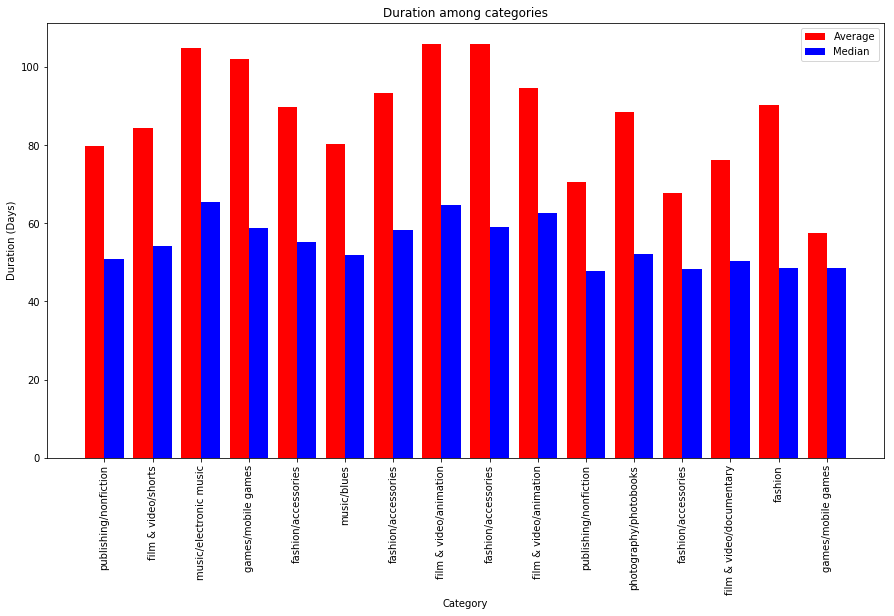

In [254]:
categories = list(df1['category_name'])
basic_categories = []
for i in categories:
    if '/' in i:
        temp = re.findall(r'\w+:?(?=/)', i)[0]
        basic_categories.append(temp)
    else:
        basic_categories.append(i)
        
df3 = df1.copy()
df3['basic_categories'] = basic_categories
category_freq = df3['basic_categories'].value_counts().to_dict()

avg = []
med = []
for i in category_freq.keys():
    temp = df3.loc[df3['basic_categories'] == i]
    temp['duration'] = (temp['deadline'] - temp['created_at']) / np.timedelta64(1,'D')

    duration_lst = list(temp['duration'])
    avg.append(sum(duration_lst) / len(duration_lst))
    med.append(statistics.median(duration_lst))

_categories = np.arange(len(category_freq))
fig = plt.figure(figsize = (15,8))
plt.bar(_categories - 0.2, avg, 0.4, color = 'red')
plt.bar(_categories + 0.2, med, 0.4, color = 'blue')
plt.xticks(_categories, categories, rotation='vertical')
plt.legend(['Average', 'Median'])
plt.title('Duration among categories')
plt.xlabel('Category')
plt.ylabel('Duration (Days)')
plt.show()